In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter
using CSV
using DataFrames

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317


In [2]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [3]:
a = randn(7)

7-element Vector{Float64}:
 0.0933049397800556
 0.05942189007996281
 0.3296966336241028
 0.08911216243085812
 0.12781467735394156
 0.4641371900184918
 0.6120554827644541

In [4]:
ϕ(a, Dict("na"=>2, "nb"=>2, "ne"=>2, "nd"=>2, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false))

24-element Vector{Float64}:
 0.0933049397800556
 0.008705811787359803
 0.05942189007996281
 0.005544355875528014
 0.003530961020675183
 0.3296966336241028
 0.030762324545983967
 0.019591197122945207
 0.10869987022306586
 0.08911216243085812
 0.00831460494928175
 0.005295213120754243
 0.029379979968418166
 0.007940977493103641
 0.12781467735394156
 0.011925740773516755
 0.007594989708331827
 0.04214006885134538
 0.011389842289412163
 0.01633659174709218
 0.4641371900184918
 0.21542333115826157
 0.6120554827644541
 0.374611913982029

In [5]:
function Φ(y, u, h)
    na = length(y)
    nb = length(u)-1
    ne = length(h)-1
    ϕ([y; u; h[2:end]], Dict("na"=>na, "nb"=>nb, "ne"=>ne, "nd"=>2, "dc"=>false, "crossTerms"=>true, "noiseCrossTerms"=>false))
end

Φ (generic function with 1 method)

In [6]:
import ReactiveMP.messageout

In [7]:
data_seed, params_seed = 42, 420

(42, 420)

In [8]:
include("../helpers/data.jl")

generate_data

In [9]:
struct NonlinearNode end # Dummy structure just to make Julia happy

struct NonlinearMeta{F}
    fn       :: F   # Nonlinear function, we assume 1 float input - 1 float ouput
    nsamples :: Int # Number of samples used in approximation
    ysprev   :: Vector{Float64} # Previous outputs
    us       :: Vector{Float64} # Controls
end

In [10]:
@node NonlinearNode Deterministic [ out, in ]

In [11]:
# Rule for outbound message on `out` edge given inbound message on `in` edge
@rule NonlinearNode(:out, Marginalisation) (m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin 
    samples = [rand(m_in) for _ in 1:meta.nsamples]
    def_fn(s) = meta.fn(meta.ysprev, meta.us, s)
    return SampleList(def_fn.(samples))
end

In [12]:
testmeta = NonlinearMeta(Φ, 1000, rand(2), rand(3))

NonlinearMeta{typeof(Φ)}(Φ, 1000, [0.1867848006071715, 0.941842143783018], [0.2577213480167426, 0.31396140634563685, 0.12042981626312543])

In [13]:
check = @call_rule NonlinearNode(:out, Marginalisation) (m_in=MvNormalMeanCovariance(ones(3), diageye(3)), meta=testmeta)

SampleList(Multivariate(24), 1000)

In [14]:
# Rule for outbound message on `in` edge given inbound message on `out` edge
@rule NonlinearNode(:in, Marginalisation) (m_out::NormalDistributionsFamily, m_in::NormalDistributionsFamily, meta::NonlinearMeta) = begin 
#     @show m_in
    def_fn(s) = meta.fn(meta.ysprev, meta.us, s)
    log_m_(x) = logpdf(m_out, def_fn(x))
    samples = [rand(m_in) for _ in 1:meta.nsamples]
    weights = log_m_.(samples)
    min_val = min(weights...)
    log_norm = min_val + log(sum(exp.(weights .- min_val)))  
#     @show weights
    weights = exp.(weights .- log_norm)
    μ = sum(weights.*samples)
    tot = zeros(length(samples[1]), length(samples[1]))
    for i = 1:meta.nsamples
        tot += (samples[i] .- μ)*transpose(samples[i] .- μ).*weights[i]
    end
    Σ = (meta.nsamples/(meta.nsamples - 1)).*tot
    prec = inv(Σ) - precision(m_in)
    prec_mu = inv(Σ)*μ - weightedmean(m_in)
#     return ContinuousUnivariateLogPdf((x) -> logpdf(m_out, def_fn(x)))
    return MvNormalWeightedMeanPrecision(prec_mu, prec)
end

In [15]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [16]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [17]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [18]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function narmax(n, h_prior, w_prior, η_prior, τ_prior, y_prev, u, h_order, full_order)
        
    obs_prec = 1e12;
    
    nsamples = 100
    
    # initialize variables
    θ  = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), 1e12*diageye(h_order+1)))}
    w  = randomvar()
    h  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, LeftProposal())}
    z  = randomvar(n) where { prod_constraint = ProdGeneric(), form_constraint = SampleListFormConstraint(nsamples, RightProposal())}
    ẑ  = randomvar(n)
    y  = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    
#     Ys = [Y*y_prev[t] for t in 1:n]
#     Us = [U*u[t] for t in 1:n]
    
    AR_meta_1 = ARMeta(Multivariate, h_order+1, ARsafe())
    AR_meta_2 = ARMeta(Multivariate, full_order, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2]) where {q=MeanField()}
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1))
    
    η   ~ MvNormalMeanPrecision(η_prior[1], η_prior[2])
    τ   ~ GammaShapeRate(τ_prior[1], τ_prior[2])
    
    b = zeros(full_order); b[1] = 1.0;
    c = zeros(h_order+1); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        
        h[t] ~ AR(h_prev, θ, w) where {q = q(y,x)q(γ)q(θ), meta = AR_meta_1}
        z[t] ~ NonlinearNode(h[t]) where {pipeline=RequireInbound(in=MvNormalMeanPrecision(randn(h_order+1), 1e-1diageye(h_order+1))), meta = NonlinearMeta(Φ, nsamples, y_prev[t], u[t])}
        ẑ[t] ~ AR(z[t], η, τ) where {q = q(y, x)q(γ)q(θ), meta = AR_meta_2}
        
        y_nodes[t], y[t] ~ NormalMeanPrecision(dot(ẑ[t], b) + dot(h[t], c), obs_prec)
        
        h_prev = h[t]
    end

    return θ, w, h, η, τ, z, ẑ, y_nodes, y
end

narmax (generic function with 1 method)

In [19]:
function narmax_inference(observations, observations_prev, controls; 
                          h_order, full_order,
                          h_prior=(randn(h_order), diageye(h_order)),
                          w_prior=(1.0, 1.0), 
                          η_prior=(zeros(full_order), diageye(full_order)),
                          τ_prior=(1.0, 1.0), vmp_its=10)
        
    n = length(observations)

    # define model
    model, (θ, w, h, η, τ, z, ẑ, y_nodes, y) = narmax(n, h_prior, w_prior, η_prior, τ_prior, observations_prev, controls, h_order, full_order,
                                                      options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    z_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    θ_buffer = nothing
    w_buffer = nothing
    η_buffer = nothing
    τ_buffer = nothing
    
    subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    subscribe!(getmarginals(z), (x) -> copyto!(z_buffer, x))
    
    subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    subscribe!(getmarginal(η), (x) -> η_buffer = x)
    subscribe!(getmarginal(w), (x) -> w_buffer = x)
    subscribe!(getmarginal(τ), (x) -> τ_buffer = x)

    subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
#     fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginals!(h, MvNormalMeanPrecision(randn(h_order+1), diageye(h_order+1)))
    setmarginals!(z, MvNormalMeanPrecision(randn(full_order), diageye(full_order)))
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(randn(h_order+1), diageye(h_order+1)))
    setmarginal!(τ, GammaShapeRate(τ_prior[1], τ_prior[2]))
    setmarginal!(η, MvNormalMeanPrecision(η_prior[1], η_prior[2]))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, θ_buffer, w_buffer, η_buffer, τ_buffer, z_buffer, y_out_buffer
    
end

narmax_inference (generic function with 1 method)

In [20]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [21]:
# normalization
input = (input .- mean(input))/std(input)
output = (output .- mean(output))/std(output)

131072-element Vector{Float64}:
  0.16079923510341107
  0.22775112557812904
  0.18754101784311708
  0.06100846540391118
 -0.08957707645721216
 -0.18838039383721755
 -0.19097550097668597
 -0.10483293373486675
  0.02295126604669645
  0.13305126280854654
  0.17798502765446092
  0.1377374454481209
  0.032407948886333235
  ⋮
 -0.32807023315970646
 -0.3752131180904102
 -0.2764304116696352
 -0.08649480119047896
  0.12356085294471451
  0.28107729827796324
  0.31041980932783675
  0.217070901249631
  0.08335261893326895
 -0.03750817227043455
 -0.1286873084587455
 -0.1506604647219554

In [789]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

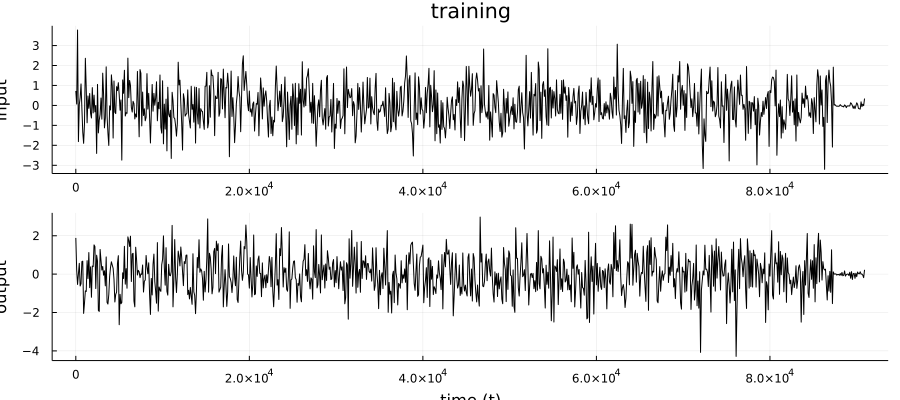

In [790]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

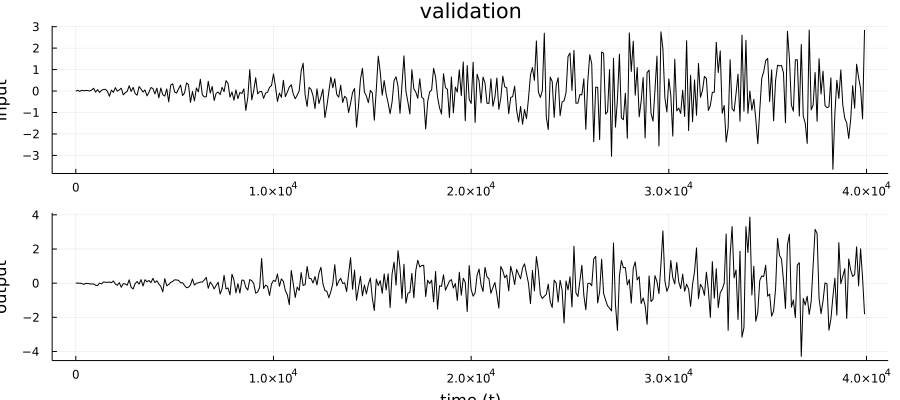

In [791]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [792]:
order_y, order_u, order_h = 2, 2, 2
full_order = 24

24

In [793]:
train_size = 100
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u+1)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u+1)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

In [794]:
order_h

2

In [795]:
coefs_mean = zeros(full_order); 
coefs_precision = diageye(full_order)
# coefs_mean[end-order_h+1:end] = zeros(order_h)
# coefs_precision[end-order_h+1:end,end-order_h+1:end] = 1e6*diageye(order_h)

fe_, h_, θ_, w_, η_, τ_, z_, y_out_ = narmax_inference(Y_train, X_train, U_train, h_order=order_h, full_order=full_order,
                                                       h_prior=(randn(order_h+1), diageye(order_h+1)),
                                                       w_prior=(1.0, 1.0), 
                                                       η_prior=(zeros(full_order), diageye(full_order)),
                                                       τ_prior=(1.0, 1.0), vmp_its=10);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [796]:
# plot(fe_[10:end])

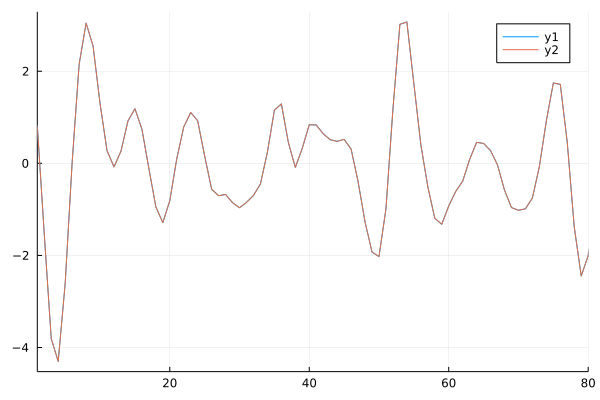

In [797]:
mfrom, mto = 1, 80
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(mfrom, mto))

In [798]:
mean(w_)

10.763992028991328

In [799]:
mean(τ_)

2.0236094986815023

In [800]:
mean(η_)

24-element Vector{Float64}:
  0.5297421897008815
  0.04221236684640827
 -0.16017613627757563
 -0.08010219774906277
  0.07494783435991424
  0.025738463186898305
 -0.002583537739499272
  0.007938622437677935
 -0.009372195986742963
  0.06340750221120499
 -0.0633054526004256
  0.03203113062139995
 -0.023494608627157514
  0.007325890087014757
  0.1448066834696565
 -0.05944827999144389
 -0.0016312826177897846
 -0.026871248272958698
 -0.020137249633519788
  0.0007737099523951359
  0.3402830551053366
  0.1000603686830462
  0.0802248981044288
  0.02488175220217506

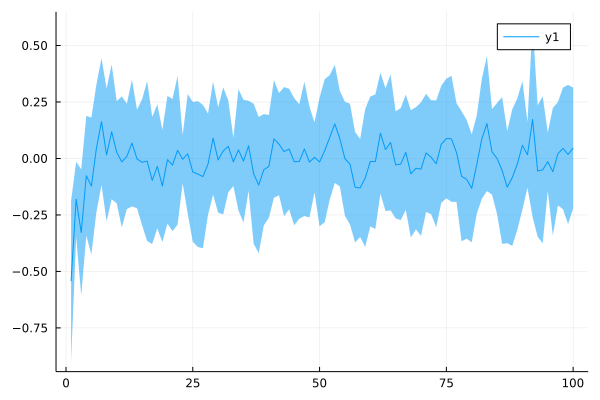

In [801]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

## KF-like prediction

In [73]:
function transition(γ, order)
    V = zeros(order, order)
#     V = diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [74]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function linear_max_prediction_mv_model(h_prior, η, w, τ, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}

    uh  ~ H*h + U*u
    yuh ~ uh + Y*y_prev
    
    c = zeros(h_order); c[1] = 1.0
    y_node, y ~ NormalMeanPrecision(dot(yuh, η) + dot(h, c), τ) where {q=FullFactorisation()}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_node, y, y_pred
end

linear_max_prediction_mv_model (generic function with 1 method)

In [75]:
function linear_max_prediction_mv(observation_prev, control; full_order, h_prior, η, w, τ, vmp_its = 50)

    # define model
    model, (h, h_0, y_node, y, y_pred) = linear_max_prediction_mv_model(h_prior, η, w, τ, observation_prev, control, full_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
#     setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    setmessage!(h, MvNormalMeanPrecision(h_prior[1], h_prior[2]))
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

linear_max_prediction_mv (generic function with 1 method)

In [76]:
h_prev = (mean(h_[end]), precision(h_[end]))
η = mean(η_)
w = mean(w_)
τ = mean(τ_)

fe_pred, h_pred, h0_pred, y_pred = linear_max_prediction_mv(X_train[1], U_train[1], full_order=full_order, h_prior=h_prev,η=η, w=w, τ=τ, vmp_its=1)

(Any[-Inf], Marginal(MvNormalWeightedMeanPrecision(
xi: [-2.4378672579209043e-12, 1.01587073196036]
Λ: [36.625524367831815 9.353816372243829e-23; 9.353816372243829e-23 40.852338243216565]
)
), Marginal(MvNormalMeanPrecision(
μ: [0.02486689319745651, 0.013126124187348232]
Λ: [40.852338243213566 1.5216697392163972e-9; 1.5216697392163972e-9 40.85237011571356]
)
), Marginal(NormalWeightedMeanPrecision{Float64}(xi=41.56684790176972, w=17.050696500210147)))

In [77]:
inv(w)

0.027303363358216072

In [78]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
η = mean(η_)
w = mean(w_)
τ = mean(τ_)

batch = 1
for i in batch:length(X_test)
    fe_pred, h_pred, h0_pred, y_pred = linear_max_prediction_mv(X_test[i], U_test[i], full_order=full_order, h_prior=h_prev,η=η, w=w, τ=τ, vmp_its=1)
    push!(predictions, y_pred)
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), diageye(full_order)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=100);
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_test[i-batch+1:i], X_test[i-batch+1:i], U_test[i-batch+1:i], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), precision(η_)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=10);
    
    h_prev = (mean(h_[end]), precision(h_[end]))
    η = mean(η_)
    w = mean(w_)
    τ = mean(τ_)
    
end

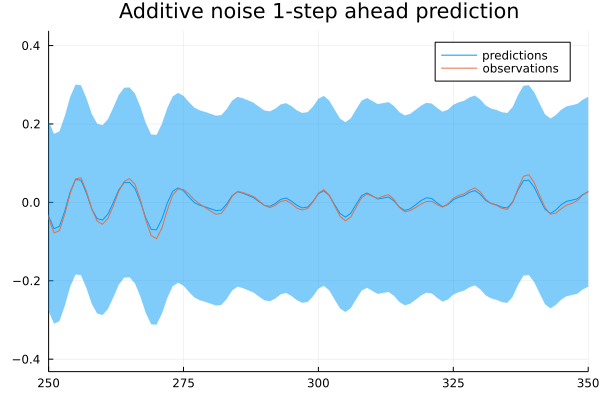

In [79]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_test, xlims=(250, 350), title="Additive noise 1-step ahead prediction", label="observations")

In [80]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
η = mean(η_)
w = mean(w_)
τ = mean(τ_)

batch = 1
for i in batch:length(X_train)
    fe_pred, h_pred, h0_pred, y_pred = linear_max_prediction_mv(X_train[i], U_train[i], full_order=full_order, h_prior=h_prev,η=η, w=w, τ=τ, vmp_its=1)
    push!(predictions, y_pred)
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), diageye(full_order)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=100);
    
#     _, h_, θ_, w_, η_, τ_, y_out_ = linear_max_inference_mv(Y_train[i-batch+1:i], X_train[i-batch+1:i], U_train[i-batch+1:i], y_order=order_y, u_order=order_u, w_prior=(shape(w_), rate(w_)), 
#                                                             η_prior=(mean(η_), precision(η_)), τ_prior=(shape(τ_), rate(τ_)), h_order=order_h, vmp_its=100);
    
#     h_prev = (mean(h_[end]), precision(h_[end]))
#     η = mean(η_)
#     w = mean(w_)
#     τ = mean(τ_)
    
end

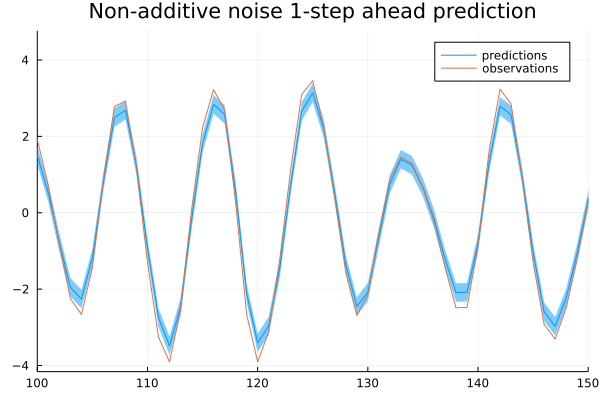

In [81]:
plot(mean.(predictions), ribbon=sqrt.(first.(cov.(predictions))), label="predictions")
plot!(Y_train, xlims=(100, 150), title="Non-additive noise 1-step ahead prediction", label="observations")

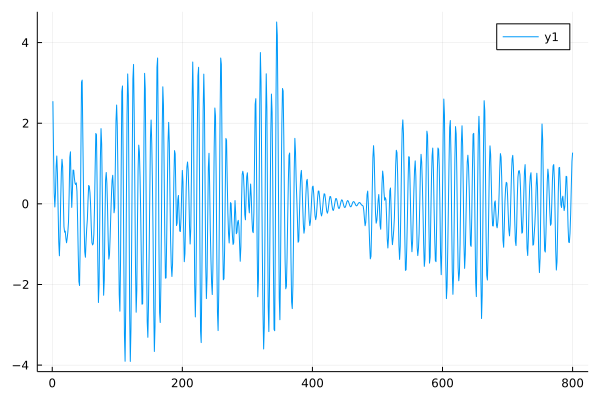

In [82]:
plot(Y_train)